# 1.B

In [46]:
import pandas as pd
# Load the Excel file
file_path = '/Users/juanjo/Library/CloudStorage/OneDrive-UniversityofOklahoma/2024 Fall/Systems Optimization/Homeworks/Homework 7/GreenTech.xlsx'
df = pd.read_excel(file_path)
# Display the first few rows of the dataframe
df.style

,Proyect,Cost,Return,Risk Category
0,A,277106,488382,High
1,B,284772,340574,High
2,C,283818,523192,Low
3,D,173086,252858,High
4,E,394319,643881,Low
5,F,327705,551351,Low
6,G,261951,520938,High
7,H,375756,504093,Low
8,I,282297,483388,Low
9,J,185709,199985,High


In [50]:
from gurobipy import Model, GRB
import pandas as pd

# Load the Excel file
file_path = '/Users/juanjo/Library/CloudStorage/OneDrive-UniversityofOklahoma/2024 Fall/Systems Optimization/Homeworks/Homework 7/GreenTech.xlsx'
df = pd.read_excel(file_path)

# Convert columns to lists for easier indexing
projects = df["Proyect"].tolist()
costs = df["Cost"].tolist()
returns = df["Return"].tolist()
high_risk = ['A', 'B', 'D']  # Define high-risk projects
budget = 2000000  # Budget in USD
alpha = 0.4  # 40% max on high-risk projects
synergy_bonus = 200000  # Additional return if both C and F are selected

# Initialize the optimization model
model = Model("GreenTech")

# Create decision variables for each project (1 if selected, 0 otherwise)
x = model.addVars(projects, vtype=GRB.BINARY, name="x")

# Objective function: Maximize total return including synergy bonus for selecting both C and F
model.setObjective(sum(returns[i] * x[projects[i]] for i in range(len(projects))) + synergy_bonus * x['C'] * x['F'], GRB.MAXIMIZE)

# Budget constraint: Total cost of selected projects must not exceed the budget
model.addConstr(sum(costs[i] * x[projects[i]] for i in range(len(projects))) <= budget, "Budget")

# High-risk constraint: Total cost of high-risk projects must not exceed 40% of the total budget
model.addConstr(sum(costs[projects.index(p)] * x[p] for p in high_risk) <= alpha * budget, "HighRisk")

# Dependency constraints:
# If A is selected, D cannot be selected
model.addConstr(x['A'] + x['D'] <= 1, "A_D_Exclusion")
# If B is selected, E must also be selected
model.addConstr(x['B'] <= x['E'], "B_E_Dependence")


# Solve the model
model.optimize()

# Verify and print the results
if model.status == GRB.OPTIMAL:
    selected_projects = [p for p in projects if x[p].x > 0.5]
    expected_return = model.objVal
    total_cost = sum(costs[projects.index(p)] for p in selected_projects)
    high_risk_cost = sum(costs[projects.index(p)] for p in selected_projects if p in high_risk)
    
    # Print results
    print("Selected projects:", selected_projects)
    print("Expected total return:", expected_return)
    print("Total cost:", total_cost)
    print("High-risk projects cost:", high_risk_cost)
    
    
else:
    print("No optimal solution found.")



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 10 columns and 17 nonzeros
Model fingerprint: 0xf8cc5c10
Model has 1 quadratic objective term
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [2e+05, 6e+05]
  QObjective range [4e+05, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 4 rows, 11 columns, 17 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective 3431837.0000

Root relaxation: objective 3.607807e+06, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

# 2.B

In [34]:
import gurobipy as gp
from gurobipy import GRB

# Sets
T = range(0, 12)  # Months 1 through 12

# Parameters (from the problem statement)
demand = [150, 200, 250, 180, 220, 300, 280, 260, 230, 240, 190, 210]
c_in = 10  # In-house production cost per unit
c_sub = 5  # Subcontracting cost per unit
h_reg = 160  # Regular labor hours per employee per month
h_ot = 40  # Maximum overtime hours per employee per month
p_h = 1.5  # Production hours required per unit
c_reg = 20  # Regular labor cost per hour
c_ot = 30  # Overtime labor cost per hour
c_hire = 500  # Hiring cost per employee
c_layoff = 750  # Layoff cost per employee
h_c = 2  # Holding cost per unit per month
b_c = 5  # Backlog cost per unit per month
initial_inventory = 50  # Initial inventory
initial_workforce = 10  # Initial workforce
H_max = 5  # Maximum hiring per month
L_max = 3  # Maximum layoffs per month

# Model
m = gp.Model("Gourmet_Granola")

# Decision variables
W = m.addVars(T, vtype=GRB.INTEGER, name="W")  # Workforce size
H = m.addVars(T, vtype=GRB.INTEGER, name="H")  # Hires
F = m.addVars(T, vtype=GRB.INTEGER, name="F")  # Layoffs
P_in = m.addVars(T, vtype=GRB.INTEGER, name="P_in")  # In-house production
P_sub = m.addVars(T, vtype=GRB.INTEGER, name="P_sub")  # Subcontracted production
I = m.addVars(T, vtype=GRB.INTEGER, name="I")  # Inventory
B = m.addVars(T, vtype=GRB.INTEGER, name="B")  # Backlog
O = m.addVars(T, vtype=GRB.CONTINUOUS, name="O")  # Overtime hours

# Objective function: Minimize total cost
m.setObjective(
    gp.quicksum(
        c_in * P_in[t] + c_reg * W[t] * h_reg + c_ot * O[t]
        + c_hire * H[t] + c_layoff * F[t] + h_c * I[t] + b_c * B[t]
        for t in T
    ),
    GRB.MINIMIZE
)

# Constraints

# Initial conditions
m.addConstr(W[0] == initial_workforce)
m.addConstr(I[0] == initial_inventory)
m.addConstr(B[11] == 0)

# Workforce balance and inventory balance constraints
for t in T:
    if t != 0:
        m.addConstr(W[t] == W[t-1] + H[t] - F[t], f"Workforce_Balance_{t}")
    if t != 0:
        m.addConstr(I[t]  == I[t-1] - B[t-1] + P_in[t] - demand[t] + B[t], f"Inventory_Balance_{t}")

# Production capacity
for t in T:
    m.addConstr(P_in[t] * p_h <= W[t] * h_reg + O[t], f"Production_Capacity_{t}")

# Overtime limit
for t in T:
    m.addConstr(O[t] <= W[t] * h_ot, f"Overtime_Limit_{t}")

# Hiring and layoff limits
for t in T:
    m.addConstr(H[t] <= H_max, f"Hiring_Limit_{t}")
    m.addConstr(F[t] <= L_max, f"Layoff_Limit_{t}")

# Non-negativity and integer constraints are implicitly handled by variable types

import pandas as pd

m.optimize()

# Output results if optimal solution found
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    print(f"Total Cost: ${m.objVal:,.2f}")
    
    # Initialize a dictionary to store the results
    results = {
        "Month": [t for t in T],
        "Workforce": [W[t].x for t in T],
        "Hired": [H[t].x for t in T],
        "Laid off": [F[t].x for t in T],
        "In-house Production": [P_in[t].x for t in T],
        "Subcontracted Production": [P_sub[t].x for t in T],
        "Inventory": [I[t].x for t in T],
        "Backlog": [B[t].x for t in T],
        "Overtime Hours": [O[t].x for t in T],
        "Demand": demand,
    }
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    df.style
else:
    print("No optimal solution found.")

df.style

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 96 columns and 186 nonzeros
Model fingerprint: 0xd228227b
Variable types: 12 continuous, 84 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e+00, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Found heuristic solution: objective 400750.00000
Presolve removed 31 rows and 23 columns
Presolve time: 0.00s
Presolved: 42 rows, 73 columns, 149 nonzeros
Variable types: 0 continuous, 73 integer (0 binary)
Found heuristic solution: objective 396400.00000

Root relaxation: objective 1.464412e+05, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 146441.

,Month,Workforce,Hired,Laid off,In-house Production,Subcontracted Production,Inventory,Backlog,Overtime Hours,Demand
0,0,10.000000,-0.000000,-0.000000,-0.000000,-0.000000,50.000000,0.000000,0.000000,150
1,1,7.000000,-0.000000,3.000000,702.000000,-0.000000,552.000000,-0.000000,0.000000,200
2,2,4.000000,-0.000000,3.000000,426.000000,-0.000000,728.000000,-0.000000,0.000000,250
3,3,1.000000,-0.000000,3.000000,106.000000,-0.000000,654.000000,-0.000000,0.000000,180
4,4,1.000000,-0.000000,0.000000,106.000000,-0.000000,540.000000,-0.000000,0.000000,220
5,5,1.000000,-0.000000,0.000000,106.000000,-0.000000,346.000000,-0.000000,0.000000,300
6,6,1.000000,0.000000,-0.000000,106.000000,-0.000000,172.000000,-0.000000,0.000000,280
7,7,1.000000,-0.000000,-0.000000,106.000000,-0.000000,18.000000,-0.000000,0.000000,260
8,8,2.000000,1.000000,-0.000000,213.000000,-0.000000,1.000000,-0.000000,0.000000,230
9,9,2.000000,-0.000000,-0.000000,213.000000,-0.000000,-0.000000,26.000000,0.000000,240


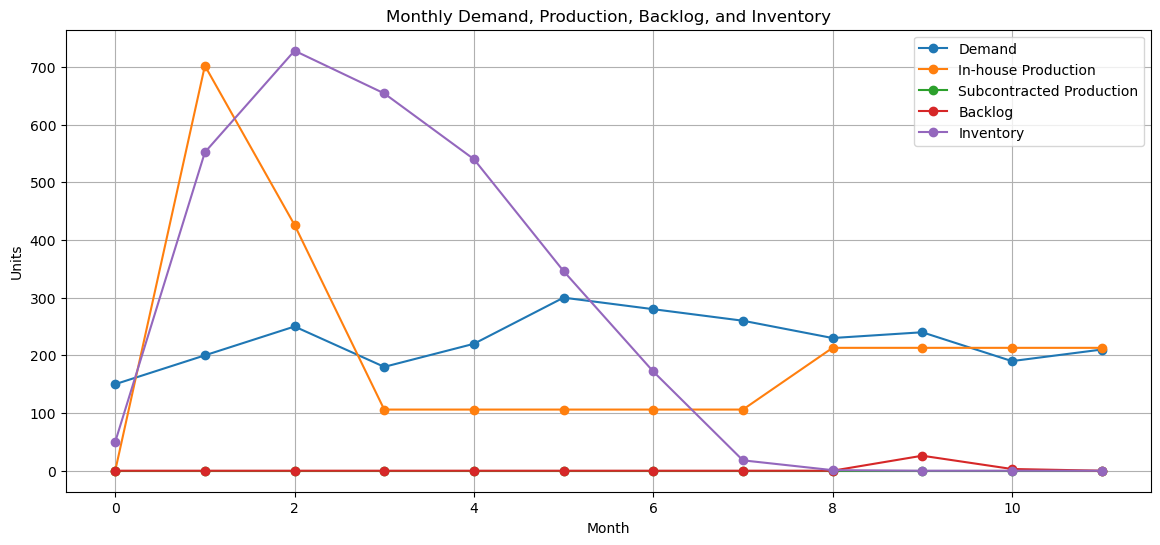

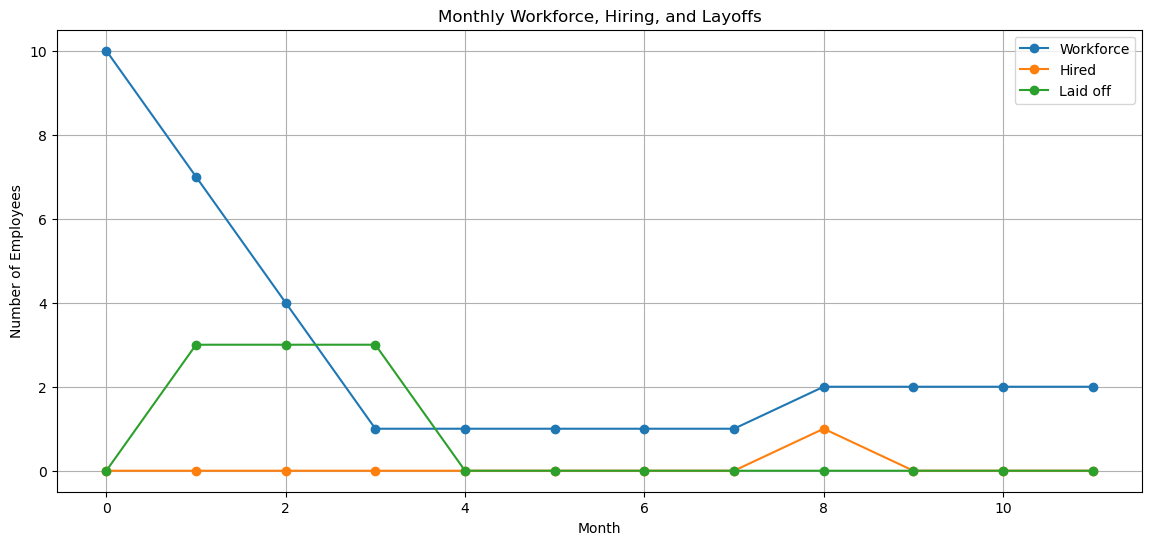

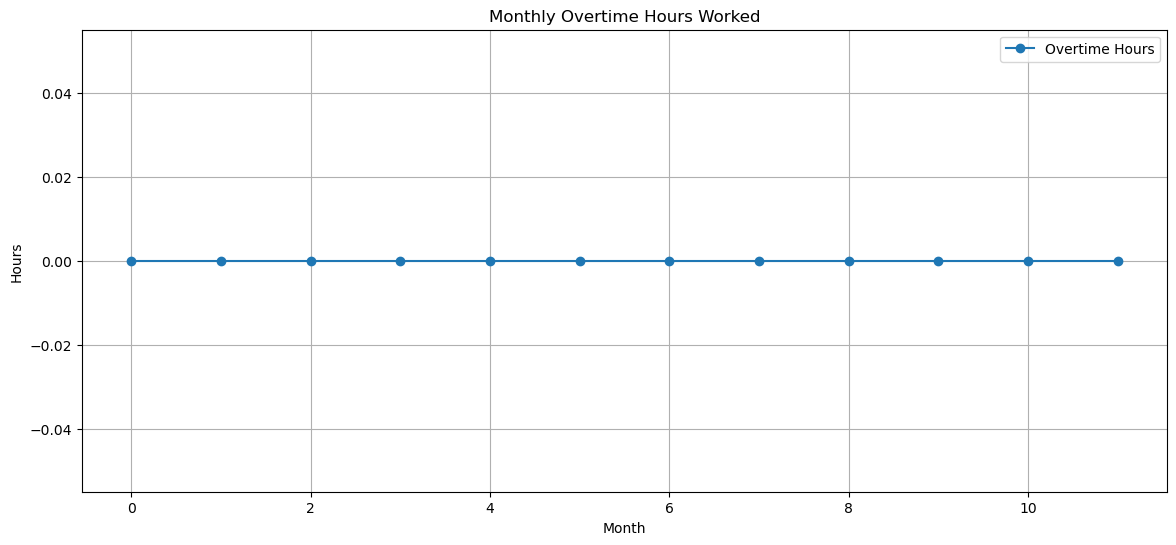

In [36]:
import matplotlib.pyplot as plt

# Plot 1: Monthly demand, production, backlog, and inventory
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Demand'], label='Demand', marker='o')
plt.plot(df['Month'], df['In-house Production'], label='In-house Production', marker='o')
plt.plot(df['Month'], df['Subcontracted Production'], label='Subcontracted Production', marker='o')
plt.plot(df['Month'], df['Backlog'], label='Backlog', marker='o')
plt.plot(df['Month'], df['Inventory'], label='Inventory', marker='o')
plt.title('Monthly Demand, Production, Backlog, and Inventory')
plt.xlabel('Month')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Monthly workforce, hiring, and layoffs
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Workforce'], label='Workforce', marker='o')
plt.plot(df['Month'], df['Hired'], label='Hired', marker='o')
plt.plot(df['Month'], df['Laid off'], label='Laid off', marker='o')
plt.title('Monthly Workforce, Hiring, and Layoffs')
plt.xlabel('Month')
plt.ylabel('Number of Employees')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Monthly number of overtime hours worked
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Overtime Hours'], label='Overtime Hours', marker='o')
plt.title('Monthly Overtime Hours Worked')
plt.xlabel('Month')
plt.ylabel('Hours')
plt.legend()
plt.grid(True)
plt.show()

# 2.C

# Without subcontracting

In [96]:
import gurobipy as gp
from gurobipy import GRB

# Sets
T = range(0, 12)  # Months 1 through 12

# Parameters (from the problem statement)
demand = [150, 200, 250, 180, 220, 300, 280, 260, 230, 240, 190, 210]
c_in = 10  # In-house production cost per unit
#c_sub = 5  # Subcontracting cost per unit
h_reg = 160  # Regular labor hours per employee per month
h_ot = 40  # Maximum overtime hours per employee per month
p_h = 1.5  # Production hours required per unit
c_reg = 20  # Regular labor cost per hour
c_ot = 30  # Overtime labor cost per hour
c_hire = 500  # Hiring cost per employee
c_layoff = 750  # Layoff cost per employee
h_c = 2  # Holding cost per unit per month
b_c = 5  # Backlog cost per unit per month
initial_inventory = 50  # Initial inventory
initial_workforce = 10  # Initial workforce
H_max = 5  # Maximum hiring per month
L_max = 3  # Maximum layoffs per month

# Model
m = gp.Model("Gourmet_Granola")

# Decision variables
W = m.addVars(T, vtype=GRB.INTEGER, name="W")  # Workforce size
H = m.addVars(T, vtype=GRB.INTEGER, name="H")  # Hires
F = m.addVars(T, vtype=GRB.INTEGER, name="F")  # Layoffs
P_in = m.addVars(T, vtype=GRB.INTEGER, name="P_in")  # In-house production
#P_sub = m.addVars(T, vtype=GRB.INTEGER, name="P_sub")  # Subcontracted production
I = m.addVars(T, vtype=GRB.INTEGER, name="I")  # Inventory
B = m.addVars(T, vtype=GRB.INTEGER, name="B")  # Backlog
O = m.addVars(T, vtype=GRB.CONTINUOUS, name="O")  # Overtime hours

# Objective function: Minimize total cost
m.setObjective(
    gp.quicksum(
        c_in * P_in[t]  + c_reg * W[t] * h_reg + c_ot * O[t]
        + c_hire * H[t] + c_layoff * F[t] + h_c * I[t] + b_c * B[t]
        for t in T
    ),
    GRB.MINIMIZE
)

# Constraints

# Initial conditions
m.addConstr(W[0] == initial_workforce)
m.addConstr(I[0] == initial_inventory)
m.addConstr(B[11] == 0)

# Workforce balance and inventory balance constraints
for t in T:
    if t != 0:
        m.addConstr(W[t] == W[t-1] + H[t] - F[t], f"Workforce_Balance_{t}")
    if t != 0:
        m.addConstr(I[t]  == I[t-1] - B[t-1] + P_in[t] - demand[t] + B[t], f"Inventory_Balance_{t}")

# Production capacity
for t in T:
    m.addConstr(P_in[t] * p_h <= W[t] * h_reg + O[t], f"Production_Capacity_{t}")

# Overtime limit
for t in T:
    m.addConstr(O[t] <= W[t] * h_ot, f"Overtime_Limit_{t}")

# Hiring and layoff limits
for t in T:
    m.addConstr(H[t] <= H_max, f"Hiring_Limit_{t}")
    m.addConstr(F[t] <= L_max, f"Layoff_Limit_{t}")

# Non-negativity and integer constraints are implicitly handled by variable types

import pandas as pd

m.optimize()

# Output results if optimal solution found
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    print(f"Total Cost: ${m.objVal:,.2f}")
    
    # Initialize a dictionary to store the results
    results = {
        "Month": [t for t in T],
        "Workforce": [W[t].x for t in T],
        "Hired": [H[t].x for t in T],
        "Laid off": [F[t].x for t in T],
        "In-house Production": [P_in[t].x for t in T],
        #"Subcontracted Production": [P_sub[t].x for t in T],
        "Inventory": [I[t].x for t in T],
        "Backlog": [B[t].x for t in T],
        "Overtime Hours": [O[t].x for t in T],
        "Demand": demand,
    }
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    df.style
else:
    print("No optimal solution found.")

df.style

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 84 columns and 186 nonzeros
Model fingerprint: 0xdb9603e3
Variable types: 12 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e+00, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Found heuristic solution: objective 400750.00000
Presolve removed 31 rows and 11 columns
Presolve time: 0.00s
Presolved: 42 rows, 73 columns, 149 nonzeros
Variable types: 0 continuous, 73 integer (0 binary)
Found heuristic solution: objective 396400.00000

Root relaxation: objective 1.464412e+05, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 146441.

,Month,Workforce,Hired,Laid off,In-house Production,Inventory,Backlog,Overtime Hours,Demand
0,0,10.000000,-0.000000,-0.000000,-0.000000,50.000000,0.000000,0.000000,150
1,1,7.000000,-0.000000,3.000000,702.000000,552.000000,-0.000000,0.000000,200
2,2,4.000000,-0.000000,3.000000,426.000000,728.000000,-0.000000,0.000000,250
3,3,1.000000,-0.000000,3.000000,106.000000,654.000000,-0.000000,0.000000,180
4,4,1.000000,-0.000000,0.000000,106.000000,540.000000,-0.000000,0.000000,220
5,5,1.000000,-0.000000,0.000000,106.000000,346.000000,-0.000000,0.000000,300
6,6,1.000000,0.000000,-0.000000,106.000000,172.000000,-0.000000,0.000000,280
7,7,1.000000,-0.000000,-0.000000,106.000000,18.000000,-0.000000,0.000000,260
8,8,2.000000,1.000000,-0.000000,213.000000,1.000000,-0.000000,0.000000,230
9,9,2.000000,-0.000000,-0.000000,213.000000,-0.000000,26.000000,0.000000,240


# Subcontracting without restrictions

In [59]:
import gurobipy as gp
from gurobipy import GRB

# Sets
T = range(0, 12)  # Months 1 through 12

# Parameters (from the problem statement)
demand = [150, 200, 250, 180, 220, 300, 280, 260, 230, 240, 190, 210]
c_in = 10  # In-house production cost per unit
c_sub = 5  # Subcontracting cost per unit
h_reg = 160  # Regular labor hours per employee per month
h_ot = 40  # Maximum overtime hours per employee per month
p_h = 1.5  # Production hours required per unit
c_reg = 20  # Regular labor cost per hour
c_ot = 30  # Overtime labor cost per hour
c_hire = 500  # Hiring cost per employee
c_layoff = 750  # Layoff cost per employee
h_c = 2  # Holding cost per unit per month
b_c = 5  # Backlog cost per unit per month
initial_inventory = 50  # Initial inventory
initial_workforce = 10  # Initial workforce
H_max = 5  # Maximum hiring per month
L_max = 3  # Maximum layoffs per month

# Model
m = gp.Model("Gourmet_Granola")

# Decision variables
W = m.addVars(T, vtype=GRB.INTEGER, name="W")  # Workforce size
H = m.addVars(T, vtype=GRB.INTEGER, name="H")  # Hires
F = m.addVars(T, vtype=GRB.INTEGER, name="F")  # Layoffs
P_in = m.addVars(T, vtype=GRB.INTEGER, name="P_in")  # In-house production
P_sub = m.addVars(T, vtype=GRB.INTEGER, name="P_sub")  # Subcontracted production
I = m.addVars(T, vtype=GRB.INTEGER, name="I")  # Inventory
B = m.addVars(T, vtype=GRB.INTEGER, name="B")  # Backlog
O = m.addVars(T, vtype=GRB.CONTINUOUS, name="O")  # Overtime hours

# Objective function: Minimize total cost
m.setObjective(
    gp.quicksum(
        c_in * P_in[t] + c_sub * P_sub[t] + c_reg * W[t] * h_reg + c_ot * O[t]
        + c_hire * H[t] + c_layoff * F[t] + h_c * I[t] + b_c * B[t]
        for t in T
    ),
    GRB.MINIMIZE
)

# Constraints

# Initial conditions
m.addConstr(W[0] == initial_workforce)
m.addConstr(I[0] == initial_inventory)
m.addConstr(B[11] == 0)

# Workforce balance and inventory balance constraints
for t in T:
    if t != 0:
        m.addConstr(W[t] == W[t-1] + H[t] - F[t], f"Workforce_Balance_{t}")
    if t != 0:
        m.addConstr(I[t]  == I[t-1] - B[t-1] + P_in[t] + P_sub[t] - demand[t] + B[t], f"Inventory_Balance_{t}")

# Production capacity
for t in T:
    m.addConstr(P_in[t] * p_h <= W[t] * h_reg + O[t], f"Production_Capacity_{t}")

# Overtime limit
for t in T:
    m.addConstr(O[t] <= W[t] * h_ot, f"Overtime_Limit_{t}")

# Hiring and layoff limits
for t in T:
    m.addConstr(H[t] <= H_max, f"Hiring_Limit_{t}")
    m.addConstr(F[t] <= L_max, f"Layoff_Limit_{t}")

# Non-negativity and integer constraints are implicitly handled by variable types

import pandas as pd

m.optimize()

# Output results if optimal solution found
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    print(f"Total Cost: ${m.objVal:,.2f}")
    
    # Initialize a dictionary to store the results
    results = {
        "Month": [t for t in T],
        "Workforce": [W[t].x for t in T],
        "Hired": [H[t].x for t in T],
        "Laid off": [F[t].x for t in T],
        "In-house Production": [P_in[t].x for t in T],
        "Subcontracted Production": [P_sub[t].x for t in T],
        "Inventory": [I[t].x for t in T],
        "Backlog": [B[t].x for t in T],
        "Overtime Hours": [O[t].x for t in T],
        "Demand": demand,
    }
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    df.style
else:
    print("No optimal solution found.")

df.style

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 96 columns and 197 nonzeros
Model fingerprint: 0x2a98d492
Variable types: 12 continuous, 84 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e+00, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Found heuristic solution: objective 90550.000000
Presolve removed 62 rows and 74 columns
Presolve time: 0.01s
Presolved: 11 rows, 22 columns, 42 nonzeros
Variable types: 0 continuous, 22 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 90550 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.055000000000e+04, best bound 9.055000000000e+04, gap 0.0000%
Optimal Solution Found!
Total Cost: $90

,Month,Workforce,Hired,Laid off,In-house Production,Subcontracted Production,Inventory,Backlog,Overtime Hours,Demand
0,0,10.000000,-0.000000,-0.000000,-0.000000,-0.000000,50.000000,0.000000,0.000000,150
1,1,7.000000,-0.000000,3.000000,-0.000000,150.000000,0.000000,0.000000,0.000000,200
2,2,4.000000,-0.000000,3.000000,-0.000000,250.000000,0.000000,0.000000,0.000000,250
3,3,1.000000,-0.000000,3.000000,-0.000000,180.000000,0.000000,0.000000,0.000000,180
4,4,-0.000000,-0.000000,1.000000,-0.000000,220.000000,0.000000,0.000000,0.000000,220
5,5,-0.000000,-0.000000,-0.000000,-0.000000,300.000000,0.000000,0.000000,0.000000,300
6,6,-0.000000,-0.000000,-0.000000,-0.000000,280.000000,0.000000,0.000000,0.000000,280
7,7,-0.000000,-0.000000,-0.000000,-0.000000,260.000000,0.000000,0.000000,0.000000,260
8,8,-0.000000,-0.000000,-0.000000,-0.000000,230.000000,0.000000,0.000000,0.000000,230
9,9,-0.000000,-0.000000,-0.000000,-0.000000,240.000000,0.000000,0.000000,0.000000,240


# Subcontracting with condition 

In [98]:
import gurobipy as gp
from gurobipy import GRB

# Sets
T = range(0, 12)  # Months 1 through 12

# Parameters (from the problem statement)
demand = [150, 200, 250, 180, 220, 300, 280, 260, 230, 240, 190, 210]
c_in = 10  # In-house production cost per unit
c_sub = 5  # Subcontracting cost per unit
h_reg = 160  # Regular labor hours per employee per month
h_ot = 40  # Maximum overtime hours per employee per month
p_h = 1.5  # Production hours required per unit
c_reg = 20  # Regular labor cost per hour
c_ot = 30  # Overtime labor cost per hour
c_hire = 500  # Hiring cost per employee
c_layoff = 750  # Layoff cost per employee
h_c = 2  # Holding cost per unit per month
b_c = 5  # Backlog cost per unit per month
initial_inventory = 50  # Initial inventory
initial_workforce = 10  # Initial workforce
H_max = 5  # Maximum hiring per month
L_max = 3  # Maximum layoffs per month
U_max = 600  # Maximum subcontracted units in total

# Model
m = gp.Model("Gourmet_Granola_Modified")
m.Params.OutputFlag = 0  # Suppress solver output

# Decision variables
W = m.addVars(T, vtype=GRB.INTEGER, name="W")  # Workforce size
H = m.addVars(T, vtype=GRB.INTEGER, name="H")  # Hires
F = m.addVars(T, vtype=GRB.INTEGER, name="F")  # Layoffs
P_in = m.addVars(T, vtype=GRB.INTEGER, name="P_in")  # In-house production
P_sub = m.addVars(T, vtype=GRB.INTEGER, name="P_sub")  # Subcontracted production
I = m.addVars(T, vtype=GRB.INTEGER, name="I")  # Inventory
B = m.addVars(T, vtype=GRB.INTEGER, name="B")  # Backlog
O = m.addVars(T, vtype=GRB.CONTINUOUS, name="O")  # Overtime hours
Z = m.addVars(range(0, 10), vtype=GRB.BINARY, name="Z")  # Indicator for starting month of subcontracting period

# Objective function: Minimize total cost
m.setObjective(
    gp.quicksum(
        c_in * P_in[t] + c_sub * P_sub[t] + h_c * I[t] + b_c * B[t] + c_hire * H[t] + c_layoff * F[t] + c_reg * W[t] * h_reg + c_ot * O[t]
        for t in T
    ),
    GRB.MINIMIZE
)

# Constraints

# Initial conditions
m.addConstr(W[0] == initial_workforce)
m.addConstr(I[0] == initial_inventory)
m.addConstr(B[11] == 0)

# Workforce balance and inventory balance constraints
for t in T:
    if t != 0:
        m.addConstr(W[t] == W[t-1] + H[t] - F[t], f"Workforce_Balance_{t}")
    if t != 0:
        m.addConstr(I[t] == I[t-1] - B[t-1] + P_in[t] + P_sub[t] - demand[t] + B[t], f"Inventory_Balance_{t}")

# Production capacity
for t in T:
    m.addConstr(P_in[t] * p_h <= W[t] * h_reg + O[t], f"Production_Capacity_{t}")

# Overtime limit
for t in T:
    m.addConstr(O[t] <= W[t] * h_ot, f"Overtime_Limit_{t}")

# Hiring and layoff limits
for t in T:
    m.addConstr(H[t] <= H_max, f"Hiring_Limit_{t}")
    m.addConstr(F[t] <= L_max, f"Layoff_Limit_{t}")

# Total subcontracting limit
m.addConstr(gp.quicksum(P_sub[t] for t in T) <= U_max, "Total_Subcontracting_Limit")

# Subcontracting can only occur in one block of three consecutive months
for t in range(0, 10):  # Loop through potential starting months of the three-month block
    m.addConstr(gp.quicksum(P_sub[t + i] for i in range(3)) <= U_max * Z[t], f"Subcontracting_Sum_{t}")

# Ensure only one three-month period is active
m.addConstr(gp.quicksum(Z[t] for t in range(0, 10)) == 1, "Single_Three_Month_Period")

# Non-negativity and integer constraints are implicitly handled by variable types

# Optimize model
m.optimize()

# Output results if optimal solution found
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    print(f"Total Cost: ${m.objVal:,.2f}")
    
    # Initialize a dictionary to store the results
    results = {
        "Month": [t for t in T],
        "Workforce": [W[t].x for t in T],
        "Hired": [H[t].x for t in T],
        "Laid off": [F[t].x for t in T],
        "In-house Production": [P_in[t].x for t in T],
        "Subcontracted Production": [P_sub[t].x for t in T],
        "Inventory": [I[t].x for t in T],
        "Backlog": [B[t].x for t in T],
        "Overtime Hours": [O[t].x for t in T],
        "Demand": demand,
    }
    
    # Create DataFrame
    df = pd.DataFrame(results)
    

else:
    print("No optimal solution found.")

df.style


Optimal Solution Found!
Total Cost: $129,160.00


,Month,Workforce,Hired,Laid off,In-house Production,Subcontracted Production,Inventory,Backlog,Overtime Hours,Demand
0,0,10.000000,-0.000000,-0.000000,-0.000000,-0.000000,50.000000,0.000000,0.000000,150
1,1,7.000000,0.000000,3.000000,742.000000,-0.000000,592.000000,-0.000000,0.000000,200
2,2,4.000000,0.000000,3.000000,426.000000,-0.000000,768.000000,-0.000000,0.000000,250
3,3,1.000000,0.000000,3.000000,106.000000,0.000000,694.000000,-0.000000,0.000000,180
4,4,1.000000,0.000000,0.000000,106.000000,0.000000,580.000000,-0.000000,0.000000,220
5,5,1.000000,0.000000,0.000000,106.000000,0.000000,386.000000,-0.000000,0.000000,300
6,6,1.000000,0.000000,0.000000,106.000000,0.000000,212.000000,-0.000000,0.000000,280
7,7,1.000000,0.000000,0.000000,106.000000,0.000000,58.000000,0.000000,0.000000,260
8,8,1.000000,0.000000,0.000000,106.000000,0.000000,-0.000000,66.000000,0.000000,230
9,9,1.000000,0.000000,0.000000,106.000000,0.000000,0.000000,200.000000,0.000000,240


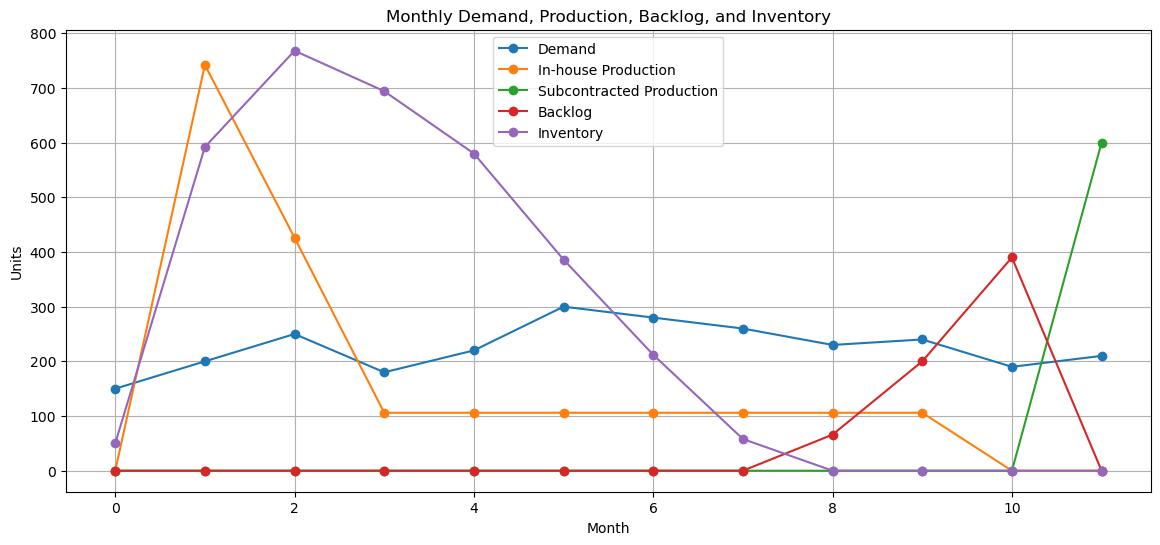

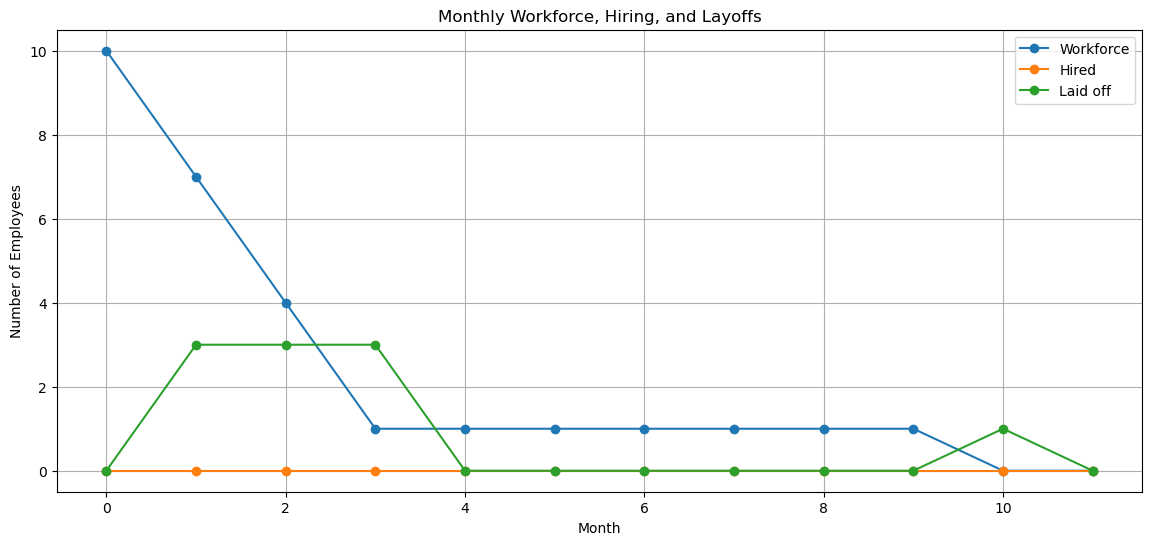

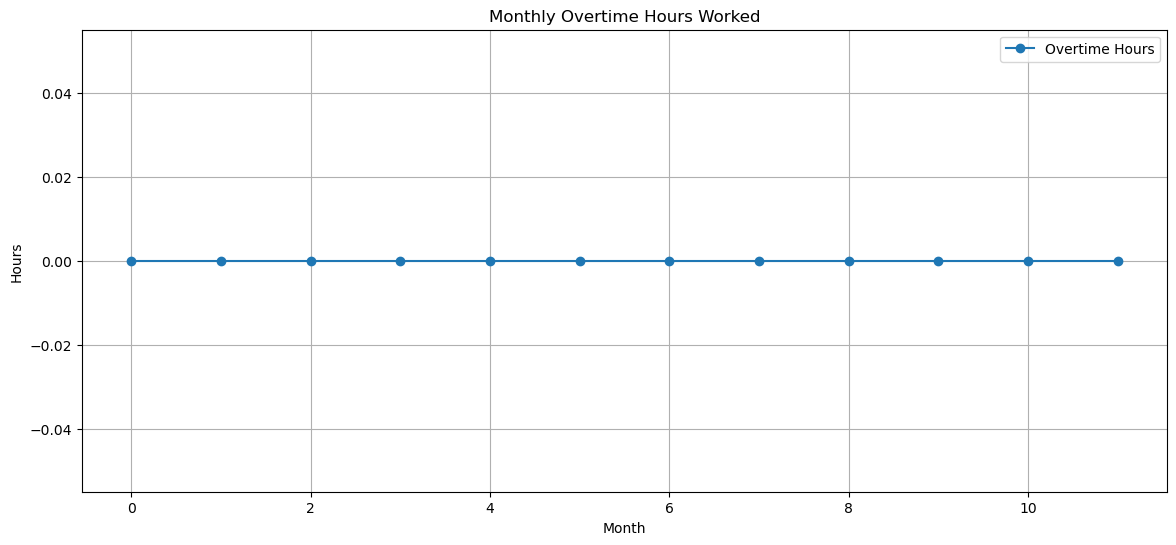

In [100]:
import matplotlib.pyplot as plt

# Assuming df is the DataFrame containing the results from the optimization model
# Plot 1: Monthly demand, production, backlog, and inventory
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Demand'], label='Demand', marker='o')
plt.plot(df['Month'], df['In-house Production'], label='In-house Production', marker='o')
plt.plot(df['Month'], df['Subcontracted Production'], label='Subcontracted Production', marker='o')
plt.plot(df['Month'], df['Backlog'], label='Backlog', marker='o')
plt.plot(df['Month'], df['Inventory'], label='Inventory', marker='o')
plt.title('Monthly Demand, Production, Backlog, and Inventory')
plt.xlabel('Month')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Monthly workforce, hiring, and layoffs
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Workforce'], label='Workforce', marker='o')
plt.plot(df['Month'], df['Hired'], label='Hired', marker='o')
plt.plot(df['Month'], df['Laid off'], label='Laid off', marker='o')
plt.title('Monthly Workforce, Hiring, and Layoffs')
plt.xlabel('Month')
plt.ylabel('Number of Employees')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Monthly number of overtime hours worked
plt.figure(figsize=(14, 6))
plt.plot(df['Month'], df['Overtime Hours'], label='Overtime Hours', marker='o')
plt.title('Monthly Overtime Hours Worked')
plt.xlabel('Month')
plt.ylabel('Hours')
plt.legend()
plt.grid(True)
plt.show()